In [1]:
import torch
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from itertools import cycle
from scipy.interpolate import griddata
import pandas as pd
import numpy as np

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class NN(nn.Module):
    '''
    input : nodes--- list
                form [input features, hiddenlayer1, hiddenlayer2,...., outputfeatures]
    '''
    def __init__(self, nodes):
        super(NN, self).__init__()
        self.act = nn.Tanh()

        self.hidden_layers = nn.ModuleList()
        for node in range(len(nodes)-2):
            self.hidden_layers.append(nn.Linear(nodes[node], nodes[node+1]))
        self.output_layer = nn.Linear(nodes[-2] , nodes[-1])
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.act(layer(x))
        x = self.output_layer(x)
        return x

In [15]:
class PINN(nn.Module):
    def __init__(self, layers, bounds_1, bounds_2 ):
        super(PINN, self).__init__()
        
        # u: T_e(1)
        # v: T_l(1)
        self.net_u_1 = NN(layers)
        self.net_v_1 = NN(layers)
        self.net_u_2 = NN(layers)
        self.net_v_2 = NN(layers)
        
        # self.net_u_1.init_weights()
        # self.net_v_1.init_weights()
        # self.net_u_2.init_weights()
        # self.net_v_2.init_weights()
        
        # for the first material, Au
        lb_1 = bounds_1[0]
        ub_1 = bounds_1[1]
        self.lb_1 = lb_1
        self.ub_1 = ub_1
        
        # for the second material, Cr
        lb_2 = bounds_2[0]
        ub_2 = bounds_2[1]
        self.lb_2 = lb_2
        self.ub_2 = ub_2
        
        
    def forward(self, X, t, material):
        if material==1:
            # X = 2.0 * ( X - self.lb_1[0] ) / ( self.ub_1[0] - self.lb_1[0] ) - 1.0
            u = self.net_u_1(torch.cat([X, t], dim=1))
            u_x = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
            
            v = self.net_v_1(torch.cat([X, t], dim=1))
            v_x = torch.autograd.grad(v, X, torch.ones_like(v), create_graph=True)[0]
            return u, u_x, v, v_x
        
        else:
            # X_2 = 2.0 * ( X - self.lb_2[0] ) / ( self.ub_2[0] - self.lb_2[0] ) - 1.0
            X_2 = X
            u_2 = self.net_u_2(torch.cat([X_2, t], dim=1))
            u_x_2 = torch.autograd.grad(u_2, X_2, torch.ones_like(u_2), create_graph=True)[0]
            
            v_2 = self.net_v_2(torch.cat([X_2, t], dim=1))
            v_x_2 = torch.autograd.grad(v_2, X_2, torch.ones_like(v_2), create_graph=True)[0]
        return u_2, u_x_2, v_2, v_x_2
    
    def f_uv(self,x, t, material):
        if material==1:
            u, u_x, v, v_x = self.forward(x, t, material=1)

            u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0] 
            
            u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
            
            v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]

            ce=2.1E-5*(u+1)
            cl=2.5E-3
            G=0.000026
            k=3.15E-5
            tp=0.1
            delta=0.153
            R=0.93
            J=1.666667E-2
            pow = x/delta+2.77*((t-2*tp)/(tp))**2
            sp = (0.94)*((1-R)/(tp*delta))*J
            S= (sp/ce)*torch.exp(-pow)
            k_ce = 1.50*(1/(u+1))
            
            f_u = u_t - k_ce*((u+1)/(v+1))*u_xx - (k_ce)*(u_x*(v+1)-v_x*(u+1))/((v+1)**2)*(u_x) + (G/ce)*(u-v) - S
            f_v = v_t - (G/cl)*(u-v)

            return f_u, f_v
        
        else:
            x_2 = x
            t_2 = t
            u_2, u_x_2, v_2, v_x_2 = self.forward(x_2, t_2, material=2)
            
            u_t_2 = torch.autograd.grad(u_2, t_2, torch.ones_like(u_2), create_graph=True)[0]
            u_xx_2 = torch.autograd.grad(u_x_2, x_2, torch.ones_like(u_x_2), create_graph=True)[0]
            
            v_t_2 = torch.autograd.grad(v_2, t_2, torch.ones_like(v_2), create_graph=True)[0]
            
            ce_2=5.8E-5*(u_2+1)
            cl_2=3.3E-3
            G_2 = 0.00042
            k_2=9.4E-6
            tp=0.1
            delta=0.153
            R=0.93
            J=1.666667E-2
            pow = x_2/delta+2.77*((t_2-2*tp)/(tp))**2
            sp = (0.94)*((1-R)/(tp*delta))*J
            S= (sp/ce_2)*torch.exp(-pow)
            
            k_ce_2 = 1.62E-1*(1/(u_2+1))
            f_u_2 = u_t_2 - k_ce_2*((u_2+1)/(v_2+1))*u_xx_2 - (k_ce_2)*(u_x_2*(v_2+1)-v_x_2*(u_2+1))/((v_2+1)**2)*(u_x_2) + (G_2/ce_2)*(u_2-v_2) - S
            f_v_2 = v_t_2 - (G_2/cl_2)*(u_2-v_2)

            return f_u_2, f_v_2

In [16]:
def loss_fn( f_u, f_v, f_u_2, f_v_2, u_x_lb, u_x_2_ub, v_x_lb, v_x_2_ub, u_1_interface, u_2_interface, v_1_interface, v_2_interface, u_x_1_interface, u_x_2_interface, u_1_initial, T_e_1_initial, v_1_initial, T_l_1_initial, u_2_initial, T_e_2_initial, v_2_initial, T_l_2_initial):
    loss = 0.0
    k1 = 3.15E-5
    k2 = 9.4E-6
    
    mse = nn.MSELoss()
    
    # loss(1) PDE1
    l1 = mse(f_u, torch.zeros_like(f_u))
    
    # loss(2) PDE1
    l2 = mse(f_v, torch.zeros_like(f_v))
    
    # loss(1) PDE2
    l3 = mse(f_u_2, torch.zeros_like(f_u_2))
    
    # loss(2) PDE2
    l4 = mse(f_v_2, torch.zeros_like(f_v_2))
    
    #loss(1) Insulated cond 1
    l5 = mse( u_x_lb, u_x_2_ub )
    
    # loss(2) Insulated cond 2
    l6 = mse( v_x_lb, v_x_2_ub )
    
    # interface loss 1
    l7 = mse( u_1_interface, u_2_interface )
    
    # interface loss 2
    vec = k1*((u_1_interface+1)/(v_1_interface+1))*u_x_1_interface - k2*((u_2_interface+1)/(v_2_interface+1))*u_x_2_interface
    l8 = mse( vec, torch.zeros_like(vec) ) 
    
    # initial condition(1) 1
    l9 = mse( u_1_initial, T_e_1_initial )
    
    # initial condition(1) 2
    l10 = mse( v_1_initial, T_l_1_initial )
    
    # initial condition(2) 1
    l11 = mse( u_2_initial, T_e_2_initial )
    
    # initial condition(2) 2
    l12 = mse( v_2_initial, T_l_2_initial )
    
    loss = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9 + l10 + l11 + l12
    return loss

In [17]:
def create_dataset():
    
    lb = torch.Tensor([0.0, 0.0])
    ub = torch.Tensor([0.5, 1.0])
    
    lb2 = torch.Tensor([0.5, 0.0])
    ub2 = torch.Tensor([1.0, 1.0])
    
    # material 1
    x = torch.linspace(0.0,0.5,100)
    t = torch.linspace(0.0,1.0,300)
    X, T = torch.meshgrid(x, t, indexing='xy')
    X_star = torch.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    X_star.requires_grad = True
    
    mesh_1 = torch.meshgrid(x, t)

    
        
    # Cr
    x_2 = torch.linspace(0.5,1.0,100)
    t_2 = torch.linspace(0.0,1.0,300)
    X_2, T_2 = torch.meshgrid(x_2, t_2, indexing='xy')
    X_star_2 = torch.hstack((X_2.flatten()[:, None], T_2.flatten()[:, None]))
    X_star_2.requires_grad = True
    
    mesh_2 = torch.meshgrid(x_2, t_2)
    
    
    train_dataloader = DataLoader( TensorDataset(X_star), batch_size=10000, shuffle=True)
    train_dataloader_2 = DataLoader( TensorDataset(X_star_2), batch_size=10000, shuffle=True)
    
    # initial condition
    X_1_initial=X_star[X_star[:,1]==0]
    X_2_initial= X_star_2[X_star_2[:,1]==0]
    
    # boundary condition
    X_1_bounds_left=X_star[X_star[:,0]==lb[0]]
    X_1_bounds_interface=X_star[X_star[:,0]==ub[0]]

    
    X_2_bounds_interface=X_star_2[X_star_2[:,0]==lb2[0]]
    X_2_bounds_right=X_star_2[X_star_2[:,0]==ub2[1]]

    return (train_dataloader, train_dataloader_2), (X_1_initial,X_2_initial), ( X_1_bounds_left, X_2_bounds_right), ( X_1_bounds_interface, X_2_bounds_interface), X, T, X_2, T_2, X_star, X_star_2

tuple_train_dataloader, initial, boundaries, interface, X_m, T_m, X_2_m, T_2_m, X_star, X_star_2 = create_dataset()

In [18]:
T_e_initial_1 = torch.Tensor([0.0]).to(device)
T_e_initial_2 = torch.Tensor([0.0]).to(device)
T_l_initial_1 = torch.Tensor([0.0]).to(device)
T_l_initial_2 = torch.Tensor([0.0]).to(device)

In [25]:

def train_pinn(pinn: PINN, epochs):
    train_losses = []
    network_u_1 = pinn.net_u_1
    network_v_1 = pinn.net_v_1
    network_u_2 = pinn.net_u_2
    network_v_2 = pinn.net_v_2
    
    network_u_1.to(device)
    network_v_1.to(device)
    network_u_2.to(device)
    network_v_2.to(device)
    
    network_u_1.train()
    network_v_1.train()
    network_u_2.train()
    network_v_2.train()
    # pinn.train()
    optimizer = torch.optim.Adam( 
                                 [
                *network_u_1.parameters(),
                *network_v_1.parameters(),
                *network_u_2.parameters(),
                *network_v_2.parameters()
                                ]
                                 , lr=0.0001 )
    
    # optimizer = torch.optim.Adam( 
    #                              pinn.parameters()
    #                              , lr=0.0001 )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for tr_loader_1, tr_loader_2 in zip(tuple_train_dataloader[0], tuple_train_dataloader[1]):
            

            X_1_initial, X_2_initial = initial
            X_1_bounds_interface, X_2_bounds_interface = interface
            X_1_bounds_left, X_2_bounds_right = boundaries
            
            X_star = tr_loader_1[0]
            X_star_2 = tr_loader_2[0]
            
            # full grid
            ## X_star: [X_full, T_full]; X_full \belongsto [0,0.5], T_full \belongsto [0,1]
            X_f = X_star[:, 0:1]
            t_f = X_star[:, 1:2]
            X_f = X_f.to(device)
            t_f = t_f.to(device)
            
            ## X_star_2: [X_full, T_full]; X_full \belongsto [0.5,1], T_full \belongsto [0,1]
            X_f_2 = X_star_2[:, 0:1]
            t_f_2 = X_star_2[:, 1:2]
            X_f_2 = X_f_2.to(device)
            t_f_2 = t_f_2.to(device)
            
            # interface boundary
            X_int_1 = X_1_bounds_interface[:,0:1]
            t_int_1 = X_1_bounds_interface[:,1:2]
            X_int_1 = X_int_1.to(device)
            t_int_1 = t_int_1.to(device)
            
            X_int_2 = X_2_bounds_interface[:,0:1]
            t_int_2 = X_2_bounds_interface[:,1:2]
            X_int_2 = X_int_2.to(device)
            t_int_2 = t_int_2.to(device)
            
            # left boundary
            X_lb_1 = X_1_bounds_left[:,0:1]
            t_lb_1 = X_1_bounds_left[:,1:2]
            X_lb_1 = X_lb_1.to(device)
            t_lb_1 = t_lb_1.to(device)
            
            
            # upper/right boundary
            X_ub_2 = X_2_bounds_right[:,0:1]
            t_ub_2 = X_2_bounds_right[:,1:2]
            X_ub_2 = X_ub_2.to(device)
            t_ub_2 = t_ub_2.to(device)
            
            # initial condition
            X_initial_1 = X_1_initial[:, 0:1]
            t_initial_1 = X_1_initial[:, 1:2]
            X_initial_1 = X_initial_1.to(device)
            t_initial_1 = t_initial_1.to(device)
            
            X_initial_2 = X_2_initial[:, 0:1]
            t_initial_2 = X_2_initial[:, 1:2]
            X_initial_2 = X_initial_2.to(device)
            t_initial_2 = t_initial_2.to(device)

            
            optimizer.zero_grad()

           # Over the domain   
            f_u, f_v = pinn.f_uv(X_f, t_f, material=1)
            f_u_2, f_v_2 = pinn.f_uv(X_f_2, t_f_2, material=2)
            
            # left boundary conditions - 1
            _, u_x_lb, _, v_x_lb = pinn.forward(X_lb_1, t_lb_1, material=1)
            
            # right/upper boundary conditions - 2
            _, u_x_ub_2, _, v_x_ub_2 = pinn.forward(X_ub_2, t_ub_2, material=2)
            
            # interface condition(1)
            u_interface_1, u_x_interface_1, v_interface_1, _ = pinn.forward( X_int_1, t_int_1, material=1 )
            u_interface_2, u_x_interface_2, v_interface_2, _ = pinn.forward( X_int_2, t_int_2, material=2)
            
            # initial conditions(1)
            u_initial_1, _, v_initial_1, _ = pinn.forward( X_initial_1, t_initial_1, material=1 )
            u_initial_2, _, v_initial_2, _ = pinn.forward( X_initial_2, t_initial_2, material=2 )
            
            
            loss = loss_fn( f_u, f_v, f_u_2, f_v_2, u_x_lb, u_x_ub_2, v_x_lb, v_x_ub_2, u_interface_1, u_interface_2, v_interface_1, v_interface_2, u_x_interface_1, u_x_interface_2, u_initial_1, T_e_initial_1, v_initial_1, T_l_initial_1, u_initial_2, T_e_initial_2, v_initial_2, T_l_initial_2)

            loss.backward(retain_graph=True)
            optimizer.step()
            epoch_loss = epoch_loss + loss.item()
        scheduler.step()
        train_losses.append(epoch_loss / len(tr_loader_1[0]))
        if epoch % 100 == 0:
            print(f'Epoch {epoch} Loss: {epoch_loss / len(tr_loader_1[0])}')
        
    return train_losses 

In [26]:
def test_pinn(pinn: PINN, X_star, t_star, X_star_2, t_star_2):
    

    # network_u_1 = pinn.net_u_1
    # network_v_1 = pinn.net_v_1
    # network_u_2 = pinn.net_u_2
    # network_v_2 = pinn.net_v_2
    
    # network_u_1.to(device)
    # network_v_1.to(device)
    # network_u_2.to(device)
    # network_v_2.to(device)
    
    # # network_u_1.eval()
    # # network_v_1.eval()
    # # network_u_2.eval()
    # # network_v_2.eval()
    
    u_pred_1, _, v_pred_1, _ = pinn.forward(X_star, t_star, material=1)
    u_pred_2, _, v_pred_2, _ = pinn.forward(X_star_2, t_star_2, material=2)
    return u_pred_1, v_pred_1, u_pred_2, v_pred_2

In [27]:
layers = [2, 80, 80, 80, 80, 80,  1]
bounds_1 = torch.Tensor( [ [0.0, 0.0], [0.5, 1.0] ] )
bounds_2 = torch.Tensor( [ [0.5, 0.0], [1.0, 1.0] ] )

network_u_1 = NN(layers).to(device)
network_v_1 = NN(layers).to(device)
network_u_2 = NN(layers).to(device)
network_v_2 = NN(layers).to(device)


pinn = PINN(layers, bounds_1 , bounds_2 ).to(device)
train_losses = train_pinn(pinn, epochs=1000)

/home/pkota2/.conda/envs/dlps/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 38.948409375
Epoch 100 Loss: 21.697409375
Epoch 200 Loss: 21.6972375
Epoch 300 Loss: 21.6972390625
Epoch 400 Loss: 21.6972375
Epoch 500 Loss: 21.69723671875
Epoch 600 Loss: 21.69723828125
Epoch 700 Loss: 21.69723671875
Epoch 800 Loss: 21.69723671875
Epoch 900 Loss: 21.69723671875


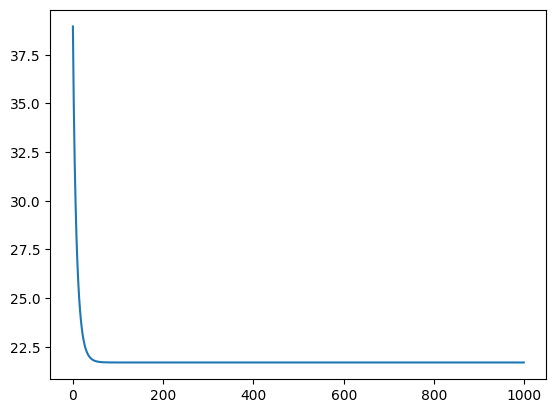

In [28]:
plt.plot(train_losses)

In [61]:
torch.save(pinn.state_dict(), '/scratch4/lgraham1/Vindhya/dlps/q1.pt')

In [43]:


u_pred_1, v_pred_1, u_pred_2, v_pred_2 = test_pinn(pinn, X_star= X_star[:,0:1].to(device),  t_star= X_star[:,1:2].to(device), X_star_2= X_star_2[:,0:1].to(device), t_star_2= X_star_2[:,1:2].to(device) )

u_pred_1 = u_pred_1.cpu().detach().numpy()
u_pred_2 = u_pred_2.cpu().detach().numpy()
v_pred_1 = v_pred_1.cpu().detach().numpy()
v_pred_2 = v_pred_2.cpu().detach().numpy()

x = torch.linspace(0.0,0.5,100)
t = torch.linspace(0.0,1.0,300)
X, T = torch.meshgrid(x, t, indexing='xy')

X_numpy = X.detach().numpy().flatten()
T_numpy = T.detach().numpy().flatten()

# Reshape u_pred_1.flatten() if needed

# Prepare the points and values for griddata
points = np.column_stack((X_star[:, 0].detach().numpy(), X_star[:, 1:2].detach().numpy()))

# Interpolate using griddata
U_pred_1 = griddata(points=points, values=u_pred_1.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic')
V_pred_1 = griddata( points=points, values=v_pred_1.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic' )
U_pred_2 = griddata(points=points, values=u_pred_2.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic')
V_pred_2 = griddata(points=points, values=v_pred_2.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic')


# U_pred_1 = griddata( points = X_star[:,0:1].detach().numpy(), values =  u_pred_1.flatten().reshape(-1,1), xi =  (X,T), method='cubic')
# V_pred_1 = griddata( X_star[:,0:1].detach().numpy(), v_pred_1.flatten()[:,None], ( X_m, T_m ), method='cubic')

# U_pred_2 = griddata( X_star_2[:,0:1].detach().numpy(), u_pred_2.flatten()[:,None], ( X_2_m, T_2_m ), method='cubic')
# V_pred_2 = griddata( X_star_2[:,0:1].detach().numpy(), v_pred_2.flatten()[:,None], ( X_2_m, T_2_m ), method='cubic')

U_pred_1 = U_pred_1*300 + 300
V_pred_1 = V_pred_1*300 + 300
U_pred_2 = U_pred_2*300 + 300
V_pred_2 = V_pred_2*300 + 300

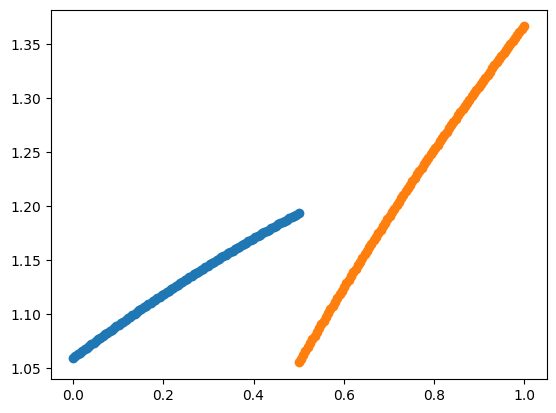

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.scatter(X_star[X_star[:, 1] == 1][:, 0].cpu().detach().numpy(), u_pred_1[X_star.cpu()[:, 1] == 1])
plt.scatter(X_star_2[X_star_2[:, 1] == 1][:, 0].cpu().detach().numpy(), u_pred_2[X_star_2[:, 1].cpu() == 1])

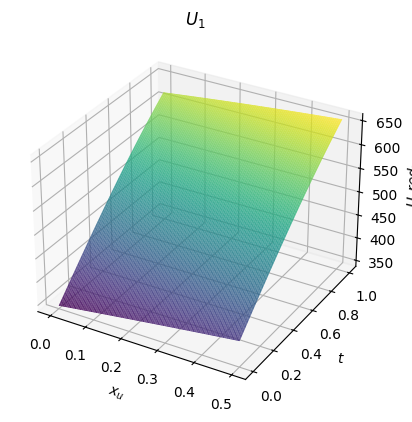

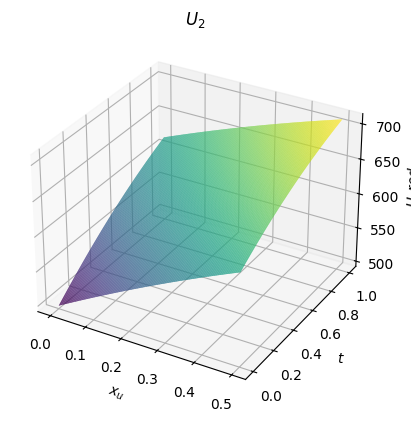

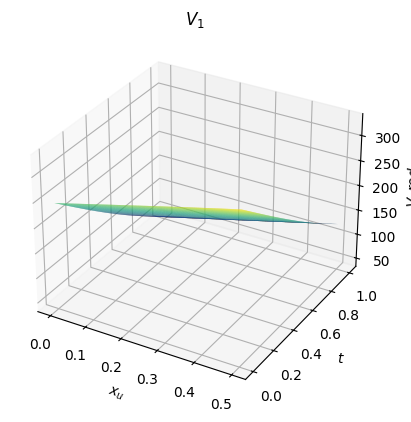

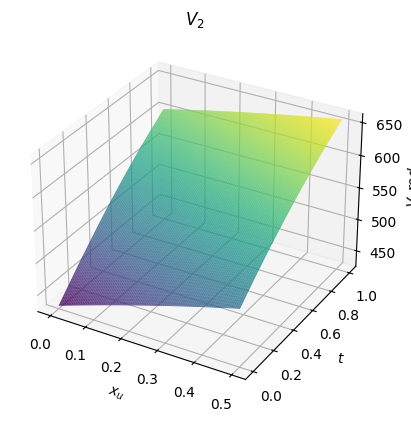

In [54]:
fig = plt.figure()
X, T = torch.meshgrid(x, t, indexing='xy')
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U_pred_1.reshape(X.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$x_u$')
ax.set_ylabel('$t$')
ax.set_zlabel('$U_pred_1$')
ax.set_title('$U_1$')
plt.savefig('surf.pdf')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U_pred_2.reshape(X.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$x_u$')
ax.set_ylabel('$t$')
ax.set_zlabel('$U_pred_2$')
ax.set_title('$U_2$')
plt.savefig('surf.pdf')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, V_pred_1.reshape(X.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$x_u$')
ax.set_ylabel('$t$')
ax.set_zlabel('$V_pred_1$')
ax.set_title('$V_1$')
plt.savefig('surf.pdf')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, V_pred_2.reshape(X.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$x_u$')
ax.set_ylabel('$t$')
ax.set_zlabel('$V_pred_2$')
ax.set_title('$V_2$');
plt.savefig('surf.pdf')

# NTTM

In [63]:
class NTTM(nn.Module):
    def __init__(self, layers, bounds):
        super(NTTM, self).__init__()
        self.net_T1 = NN(layers)
        self.net_T2 = NN(layers)
        self.net_q = NN(layers)
        
        self.lb = bounds[0]
        self.ub = bounds[1]
        
    def forward(self, X, t, variable):
        if variable == 'T1':
            X = 2.0 * ( X - self.lb ) / ( self.ub - self.lb ) - 1.0
            T1 = self.net_T1(torch.cat([X, t], dim=1))
            T1_x = torch.autograd.grad(T1, X, torch.ones_like(T1), create_graph=True)[0]
            return T1, T1_x
        elif variable == 'T2':
            X = 2.0 * ( X - self.lb ) / ( self.ub- self.lb ) - 1.0
            T2 = self.net_T2(torch.cat([X, t], dim=1))
            T2_x = torch.autograd.grad(T2, X, torch.ones_like(T2), create_graph=True)[0]
            return T2, T2_x
        else:
            X = 2.0 * ( X - self.lb) / ( self.ub - self.lb ) - 1.0
            q = self.net_q(torch.cat([X, t], dim=1))
            q_x = torch.autograd.grad(q, X, torch.ones_like(q), create_graph=True)[0]
            q_xx = torch.autograd.grad(q_x, X, torch.ones_like(q_x), create_graph=True)[0]
            return q, q_xx
        
    def f_quv(self, X, t):
        q, q_xx = self.forward(X, t, variable='q')
        T1, T1_x = self.forward(X, t, variable='T1')
        T2, T2_x = self.forward(X, t, variable='T2')
            
        q_t = torch.autograd.grad(q, t, torch.ones_like(q), create_graph=True)[0]
        q_tx = torch.autograd.grad(q_t, X, torch.ones_like(q_t), create_graph=True)[0]
        q_xxx = torch.autograd.grad(q_xx, X, torch.ones_like(q_xx), create_graph=True)[0]
            
        T1_t = torch.autograd.grad(T1, t, torch.ones_like(T1), create_graph=True)[0]
        T1_xx = torch.autograd.grad(T1_x, X, torch.ones_like(T1_x), create_graph=True)[0]
            
        T2_t = torch.autograd.grad(T2, t, torch.ones_like(T2), create_graph=True)[0]

        ce=2.1E-5*(T1+1)
        cl=2.5E-3
        G=0.0000182
        k=0.00006615
        beta = 0.333333333333333
        k_ce = beta*k/ce
        tp= 0.142857142857143
        delta= 0.153
        R=0.93
        J=0.000446666666666667
        pow = X/delta+2.77*((t-2*tp)/(tp))**2
        sp = (0.94)*((1-R)/(tp*delta))*J
        S= (sp/ce)*torch.exp(-pow)
        tau1 = 0.039
        l_e = 0.377
        new_cons = beta*l_e**2
        new_bt = beta*tau1
        G_new = G/ce
        G_new1 = G/cl
        # tau = 0.039
        tau = nn.Parameter(torch.tensor([0.039])).to(device)
        tau_inv = 1.0/tau
        k_tau = k/tau
        le_tau = l_e**2/tau
        
        
            
        f_q = tau*q_t + q +  (k)*T1_x  - (l_e**2)**2*q_xx 
        f_T1 = T1_t - (k_ce*((T1+1)/(T2+1))*T1_xx + (k_ce)*(T1_x*(T2+1)-T2_x*(T1+1))/((T2+1)**2)*(T1_x)) + new_cons*q_xxx - new_bt*q_tx  + G_new*(T1-T2) - S
        f_T2 = T2_t - G_new1*(T1-T2)

        return f_q, f_T1, f_T2

In [64]:
### CHANGE THIS LATER
T1_initial = torch.Tensor([0.0]).to(device)
T2_initial = torch.Tensor([0.0]).to(device)
q_initial = torch.Tensor([0.0]).to(device)

In [65]:
def get_exp_data():
    T1_lb = pd.read_csv('T_20nm.csv')
    T1_ub = pd.read_csv('T_100nm.csv')
    T1_lb_data = T1_lb.to_numpy()
    T1_lb_data = torch.from_numpy(T1_lb_data)
    T1_ub_data = T1_ub.to_numpy()
    T1_ub_data = torch.from_numpy(T1_ub_data)
    return T1_lb_data, T1_ub_data

T1_lb_data, T1_ub_data = get_exp_data()
T1_lb_data.to(device)
T1_ub_data.to(device)

tensor([[0.8424, 0.9570],
        [0.8305, 0.7187],
        [0.9051, 0.7054],
        [0.9898, 0.5854],
        [1.0698, 0.5921],
        [1.1441, 0.5188],
        [1.2292, 0.4822],
        [1.3091, 0.4639],
        [1.3889, 0.4172],
        [1.4634, 0.3839],
        [1.5432, 0.3406],
        [1.6231, 0.3240],
        [1.7136, 0.3024],
        [1.7775, 0.2757],
        [1.8627, 0.2608],
        [1.9426, 0.2375],
        [2.0278, 0.2208],
        [2.1077, 0.1942],
        [2.1930, 0.1892],
        [2.2730, 0.1859],
        [2.3476, 0.1726],
        [2.4222, 0.1643],
        [2.5128, 0.1527],
        [2.5928, 0.1527],
        [2.6674, 0.1461],
        [2.7528, 0.1445],
        [2.8274, 0.1328],
        [2.9127, 0.1345],
        [2.9927, 0.1362],
        [3.0781, 0.1363],
        [3.1580, 0.1330],
        [3.2380, 0.1297],
        [3.3126, 0.1180],
        [3.4033, 0.1281],
        [3.4780, 0.1264],
        [3.5526, 0.1198],
        [3.6379, 0.1132],
        [3.7179, 0.1132],
        [3.7

In [71]:
def loss_nttm(T1_initial_pred, T2_initial_pred, q_initial_pred, q_lb_pred, q_ub_pred, T1_lb_pred, T2_lb_pred, T1_x_lb_pred, T1_ub_pred, T2_ub_pred, T1_x_ub_pred, q_xx_lb_pred, q_xx_ub_pred, f_T1_pred, f_T2_pred, f_q_pred, T1_lb_data, T1_ub_data):
    k=0.00006615
    le = 0.377
    mse = nn.MSELoss()
    loss = 0.0
    
    # initial condition 1
    l1 = mse( T1_initial, T1_initial_pred )
    
    # initial condition 2
    l2 = mse( T2_initial, T2_initial_pred )
    
    # initial condition 3
    l3 = mse( q_initial, q_initial_pred )
    
    # continuity condition - on q
    l4 = mse( q_lb_pred, q_ub_pred )
    
    # continuity condition - on q_xx
    vec_lb = k * (T1_lb_pred + 1) / (T2_lb_pred + 1) * T1_x_lb_pred - (le**2) * q_xx_lb_pred
    vec_ub =  k * (T1_ub_pred + 1) / (T2_ub_pred + 1) * T1_x_ub_pred - (le**2) * q_xx_ub_pred
    l5 = mse( vec_lb, vec_ub )
    
    # PDE 1
    l6 = mse( f_T1_pred, torch.zeros_like(f_T1_pred) )
    
    # PDE 2
    l7 = mse( f_T2_pred, torch.zeros_like(f_T2_pred) )
    
    # PDE 3
    l8 = mse( f_q_pred, torch.zeros_like(f_q_pred) )
    
    # Extract time steps from X_data
    time_steps_data = T1_lb_data[:, 0].cpu()
    time_steps_pred = np.linspace(0.0,1.0,500)
    common_time_steps = np.intersect1d(time_steps_data, time_steps_pred)
    indices_data = np.searchsorted(time_steps_data, common_time_steps)
    indices_pred = np.searchsorted(time_steps_pred, common_time_steps)

    
    data_at_common_time_steps = T1_lb_data[indices_data, 1].to(device)
    pred_at_common_time_steps = T1_lb_pred[indices_pred].to(device)
    
    # data loss 1
    data_at_common_time_steps.to(device)
    pred_at_common_time_steps.to(device)
    
    l9 = mse( data_at_common_time_steps, pred_at_common_time_steps )
    
    time_steps_data = T1_ub_data[:, 0].cpu()
    time_steps_pred = np.linspace(0.0,1.0,500)
    common_time_steps = np.intersect1d(time_steps_data, time_steps_pred)
    indices_data = np.searchsorted(time_steps_data, common_time_steps)
    indices_pred = np.searchsorted(time_steps_pred, common_time_steps)
        
    data_at_common_time_steps = T1_ub_data[indices_data, 1].to(device)
    pred_at_common_time_steps = T1_ub_pred[indices_pred].to(device)
    
    # data loss 2
    data_at_common_time_steps.to(device)
    pred_at_common_time_steps.to(device)
    
    l10 = mse( data_at_common_time_steps, pred_at_common_time_steps )
    
    loss = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9 + l10
    return loss

In [72]:
def create_dataset_nttm():
    
    lb = torch.Tensor([0.0, 0.0])
    ub = torch.Tensor([1.0, 1.0])
    
    # material 1
    x = torch.linspace(0.0,1.0,100)
    t = torch.linspace(0.0,1.0,100)
    X, T = torch.meshgrid(x, t)
    X_star = torch.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    X_star.requires_grad = True

    train_dataloader = DataLoader( TensorDataset(X_star), batch_size=10000, shuffle=True)
    
    # initial condition
    X_initial=X_star[X_star[:,1]==0]

    
    # boundary condition
    X_bounds_left=X_star[X_star[:,0]==lb[0]]
    X_bounds_right=X_star[X_star[:,0]==ub[0]]


    return train_dataloader, X_initial, X_bounds_left, X_bounds_right, (X,T), X_star

train_dataloader, initial, left, right, mesh_nttm, X_star_nttm = create_dataset_nttm()

In [73]:


def train_nttm(nttm: NTTM,train_dataloader, initial, left, right, epochs):
    train_losses = []
    network_T1 = nttm.net_T1
    network_T2 = nttm.net_T2
    network_q = nttm.net_q
    
    network_T1.to(device)
    network_T2.to(device)
    network_q.to(device)

    network_T1.train()
    network_T2.train()
    network_q.train()
    
    # optimizer = torch.optim.Adam( 
    #                              [
    #             *network_T1.parameters(),
    #             *network_T2.parameters(),
    #             *network_q.parameters()
    #                             ]
    #                              , lr=0.0001,  betas=(0.99, 0.999) )
    
    optimizer = torch.optim.Adam( nttm.parameters(), lr=0.0001,  betas=(0.99, 0.999) )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for tr_loader in train_dataloader:
            

            X_initial = initial
            X_bounds_left = left
            X_bounds_right = right
            X_star = tr_loader[0]
            
            # full grid
            ## X_star: [X_full, T_full]; X_full \belongsto [0,0.5], T_full \belongsto [0,1]
            X_f = X_star[:, 0:1]
            t_f = X_star[:, 1:2]
            X_f = X_f.to(device)
            t_f = t_f.to(device)

            # left boundary
            X_lb = X_bounds_left[:,0:1]
            t_lb = X_bounds_left[:,1:2]
            X_lb = X_lb.to(device)
            t_lb = t_lb.to(device)
               
            # upper/right boundary
            X_ub = X_bounds_right[:,0:1]
            t_ub = X_bounds_right[:,1:2]
            X_ub = X_ub.to(device)
            t_ub = t_ub.to(device)
            
            # initial condition
            X_init = X_initial[:, 0:1]
            t_init = X_initial[:, 1:2]
            X_init = X_init.to(device)
            t_init = t_init.to(device)

            optimizer.zero_grad()
            
            # initial conditions(1)
            T1_initial_pred, _ = nttm.forward( X_init, t_init, variable='T1' )
            T2_initial_pred, _ = nttm.forward( X_init, t_init, variable='T2' )
            q_initial_pred, _ = nttm.forward( X_init, t_init, variable='q' )
            
            # left boundary
            q_lb_pred, q_xx_lb_pred = nttm.forward(X_lb, t_lb, variable='q')
            q_ub_pred, q_xx_ub_pred = nttm.forward(X_ub, t_ub, variable='q')
            
            T1_lb_pred, T1_x_lb_pred = nttm.forward(X_lb, t_lb, variable='T1')
            T1_ub_pred, T1_x_ub_pred = nttm.forward(X_ub, t_ub, variable='T1')
            
            T2_lb_pred, _ = nttm.forward(X_lb, t_lb, variable='T2')
            T2_ub_pred, _ = nttm.forward(X_ub, t_ub, variable='T2')
            
            # Over the domain   
            f_q_pred, f_T1_pred, f_T2_pred = nttm.f_quv(X_f, t_f) 

            
            loss = loss_nttm( T1_initial_pred, T2_initial_pred, q_initial_pred, q_lb_pred, q_ub_pred, T1_lb_pred, T2_lb_pred, T1_x_lb_pred, T1_ub_pred, T2_ub_pred, T1_x_ub_pred, q_xx_lb_pred, q_xx_ub_pred, f_T1_pred, f_T2_pred, f_q_pred, T1_lb_data.float(), T1_ub_data.float() )

            loss.backward(retain_graph=True)
            optimizer.step()
            epoch_loss = epoch_loss + loss.item()
        scheduler.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch} Loss: {epoch_loss}')
        train_losses.append(epoch_loss / len(tr_loader))
        
    return train_losses 

In [74]:
def test_nttm(nttm: NTTM, X_star, t_star, X_star_2, t_star_2):
    X_star = X_star.to(device)
    X_star_2 = X_star_2.to(device)
    t_star = t_star.to(device)
    t_star_2 = t_star_2.to(device)

    T1_pred, _ = nttm.forward(X_star, t_star, variable='T1')
    T2_pred, _ = nttm.forward(X_star_2, t_star_2, variable='T2')
    q_pred, _ = nttm.forward(X_star, t_star, variable='q')
    return T1_pred, T2_pred, q_pred

In [ ]:
nttm = NTTM(bounds=torch.Tensor( [0.0, 1.0] ), layers=[2, 100, 100, 100, 100, 100, 100, 100, 1])
nttm.to(device)
initial.to(device)
left.to(device)
right.to(device)
tr_losses = train_nttm(nttm, train_dataloader, initial, left, right, epochs=1000)

In [79]:
T1_pred, T2_pred, q_pred = test_nttm(nttm, X_star= X_star_nttm[:,0:1],  t_star= X_star_nttm[:,1:2], X_star_2= X_star_nttm[:,0:1], t_star_2= X_star_nttm[:,1:2] )

T1_pred = T1_pred.cpu().detach().numpy()
T2_pred = T2_pred.cpu().detach().numpy()
q_pred = q_pred.cpu().detach().numpy()

x = torch.linspace(0.0,0.5,100)
t = torch.linspace(0.0,1.0,100)
X, T = torch.meshgrid(x, t, indexing='xy')

X_numpy = X.detach().numpy().flatten()
T_numpy = T.detach().numpy().flatten()

# Reshape u_pred_1.flatten() if needed

# Prepare the points and values for griddata
points = np.column_stack((X_star_nttm[:, 0].detach().numpy(), X_star_nttm[:, 1:2].detach().numpy()))

# Interpolate using griddata
T1_pred = griddata(points=points, values=T1_pred.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic')
T2_pred = griddata( points=points, values=T2_pred.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic' )
q_pred = griddata(points=points, values=q_pred.flatten().reshape(-1,1), xi=(X_numpy, T_numpy), method='cubic')

T1_pred = T1_pred*300 + 300
T2_pred = T2_pred*300 + 300
q_pred = q_pred*300 + 300


Text(0.5, 0.92, 'T2_pred')

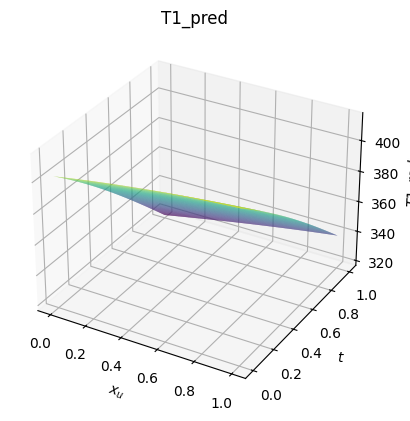

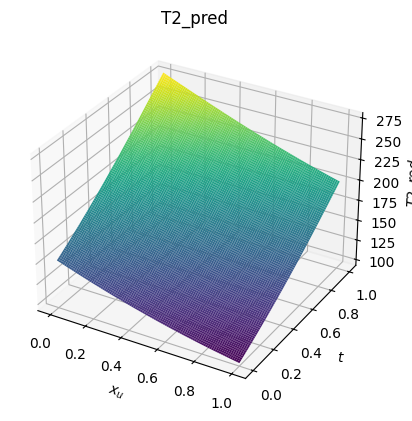

In [81]:
fig = plt.figure()
X, T = mesh_nttm
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, T1_pred.reshape(X.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$x_u$')
ax.set_ylabel('$t$')
ax.set_zlabel('$T1_pred$')
ax.set_title('T1_pred')


# fig = plt.figure()
# X, T = torch.meshgrid(x, t, indexing='xy')
# ax = plt.axes(projection='3d')
# ax.plot_surface(X, T, U_pred_1.reshape(X.shape), rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_xlabel('$x_u$')
# ax.set_ylabel('$t$')
# ax.set_zlabel('$U_pred_1$')
# ax.set_title('$U_1$')
# plt.savefig('surf.pdf')




fig = plt.figure()
X, T = mesh_nttm
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, T2_pred.reshape(X.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$x_u$')
ax.set_ylabel('$t$')
ax.set_zlabel('$T2_pred$')
ax.set_title('T2_pred')


I've trained the models for over 10000 (takes around 10h on gpu) epochs but still does not converge. For Q2, it's the same. I have tried increasing the number of grid points to 40000, but the loss still doesn't converge. I've changed the learning rates, used a scheduler for optimization, used different batch sizes during training, used different architectures but the loss still won't converge. 

The predictions are not as expected in the paper but within the computational limits, I believe they are reasonable.